In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy
import os
import h5py
from sklearn.linear_model import TweedieRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, GridSearchCV
from tqdm import tqdm
from sklearn.model_selection import cross_val_score

In [3]:
# https://rayheberer.medium.com/generating-matplotlib-subplots-programmatically-cc234629b648
def psth_plot(responsive_cells):
    """
    Plots peristimulus time histograms for all responsive cells
    
    Parameters
    ----------
    responsive_cells: numpy array
        An array of subset of cells in form [cell_num,spikes,time]
        
    Returns
    -------
    fig, axes: matplotlib figure and axes
        Array of PSTH plots
    
    """
    num_cols = np.around(np.sqrt(len(responsive_cells))).astype(int)
    fig, axes = plt.subplots(nrows=num_cols, ncols=num_cols, figsize=(48,32))
    fig.subplots_adjust(hspace=0.9)
    fig.suptitle('PSTH for each cell')
    cell_counter = 0 
    for ax, cell in zip(axes.flatten(), responsive_cells):
        ax.plot(np.arange(0,59), cell, c='grey')
        ax.plot(np.arange(0,59), np.mean(cell, axis=1), label = 'Mean')
        ax.axvline(x = 14,color= 'r', label='Stimulus onset')
        ax.set(title=str(cell_counter))
        cell_counter+=1

# Parse the results pupil mat file

In [8]:
# location of pupil test struct
# data_dir=r"C:\Users\Mitchell\Documents\PITT\Fall_2021\Williamson_lab\2P\Data\NS_results_120&154_9.3.21.mat"
data_dir=r"D:\Projects\2P\test_data\NS_results_120&154_9.3.21.mat"
day = 0
f = h5py.File(data_dir, 'r')['results']
# this package generates references that we then feed back into the original file
# I'm sure this isn't great, but it works for now
ref_1 = f['FOV'][0,0] # this can be changed for different animals
ref_2 = f[ref_1]['Day'][day][0] 
# parameter_file = np.where(f[ref_2]['Experiment']['Parameter'] == 'FreqOneD')
parameter_file = 1

In [80]:
bytes(f[f[ref_2]['Experiment']['Parameter'][1,0]][:]).decode('utf-8')

b'F\x00r\x00e\x00q\x00O\x00n\x00e\x00D\x00'

In [9]:
spikes_ref = f[ref_2]['Experiment']['spike_traces'][parameter_file,0] # can change out the word traces with zscores to get zscored data (THIS CAUSES PROBLEMS WITH REGRESSOR RN)
sequence_ref = f[ref_2]['Experiment']['inner_sequence'][parameter_file, 0]
index_ref = f[ref_2]['Experiment']['inner_index'][parameter_file, 0]
responsive_ref = f[ref_2]['Experiment']['resp'][parameter_file, 0]
# now that we have all our references, we can get the actual arrays
spikes = np.array(f[spikes_ref]).swapaxes(0,2)
inner_sequence = np.array(f[sequence_ref]).reshape(-1,)
inner_index = np.array(f[index_ref][:]).reshape(-1,).astype(int)
pupil = np.array(f[ref_2]['pupilStruct']['FreqOneD']['pupilMatrix']).T
resp = np.array(f[responsive_ref][:]).reshape(-1)

scaled_sequence = [np.log(i)/np.log(np.max(inner_sequence)) for i in inner_sequence]
# scaled_sequence2 = [(np.log(i) - np.log(min(inner_sequence)))/(np.log(max(inner_sequence))-np.log(min(inner_sequence))) for i in inner_sequence]

# get stimulus for each trial, stimulus is presented at frame 15
Stim = np.zeros_like(pupil)
Stim[14,:] = [scaled_sequence[i-1] for i in inner_index]

Stim = Stim.flatten(order='F')

# flatten pupil signal
pupil_resp = pupil.flatten(order='F')/100

# loop through responsive cells 
response_index = np.where(resp==1)[0]
responsive_cells = spikes[response_index,:59,:]

### ==== 3. Build the design matrix: slow version ======
# This is a necessary step before we can fit the model: assemble a matrix
# that contains the relevant regressors for each time bin of the response,
# known as a design matrix.  Each row of this matrix contains the relevant
# stimulus chunk for predicting the spike count at a given time bin
nT = len(Stim)
### Set the number of time bins of stimulus to use for predicting spikes
ntfilt = 15     # Try varying this, to see how performance changes!

# Build the design matrix: Slow version
paddedStim = np.hstack((np.zeros((ntfilt-1)), Stim))  # pad early bins of stimulus with zero
padded_pupil = np.hstack((np.zeros((ntfilt-1)), pupil_resp))
Xdsgnstim = np.zeros((nT,ntfilt))
Xdsgnpupil = np.zeros((nT,ntfilt))
for j in np.arange(nT):
    Xdsgnstim[j] = paddedStim[j:j+ntfilt]                 # grab last 'nkt' bins of stmiulus and insert into this row
    Xdsgnpupil[j] = padded_pupil[j:j+ntfilt]

Xdsgn = np.concatenate((Xdsgnstim,Xdsgnpupil,), axis = 1)

# Cross validation time! 

In [10]:
score_dict = {'Cell_num':[],
              'Combined': [], 
              'Sound_only': [], 
              'Pupil_only': []
             }
for index, cell in enumerate(tqdm(responsive_cells)):
    score_dict['Cell_num'].append(index)
    responses = np.reshape(cell.flatten(order = 'F'), (-1,1))
    
    # Construct design matrices 
    Xdsgn_final = np.hstack((Xdsgn,responses))
    Xdsgn_final= Xdsgn_final[~np.isnan(Xdsgn_final).any(axis=1)]
    X = Xdsgn_final[:,:-1]
    y = Xdsgn_final[:,-1]
    X_stim = Xdsgn_final[:,:ntfilt]
    X_pupil = Xdsgn_final[:,ntfilt:-1]
    matrix_dict = {'Combined': X, 
                   'Sound_only': X_stim, 
                   'Pupil_only': X_pupil
                  } 
    # Fit models for each matrix and store in score_dict
    for key, data in matrix_dict.items():
        n_splits = 5
        # set up k fold cross validation
        kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)


        # fit tweedie regressor with poisson (power=1)
        reg = TweedieRegressor(power=1, 
                               fit_intercept=True, 
                               alpha=0.0162, 
                               link='log', 
                               max_iter=10000)
        # add scores to the dictionary
        scores = cross_val_score(reg, data, y, cv=kf)
        score_dict[key].append(np.mean(scores))

score_df = pd.DataFrame(score_dict)

100%|██████████| 52/52 [01:04<00:00,  1.23s/it]


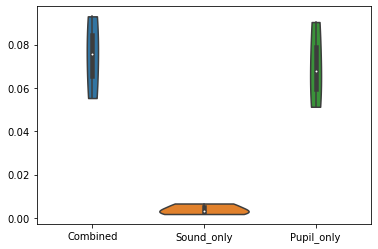

In [29]:
sns.violinplot(data=score_df.iloc[:,1:][score_df.Pupil_only > 0.05], cut=0);

In [31]:
score_df.iloc[:,1:][score_df.Pupil_only > .05]

,Combined,Sound_only,Pupil_only
1,0.075531,0.006705,0.067722
21,0.093000,0.001861,0.090366
39,0.055332,0.003438,0.051311


(-0.007896524287313527, 0.15349920527021027)

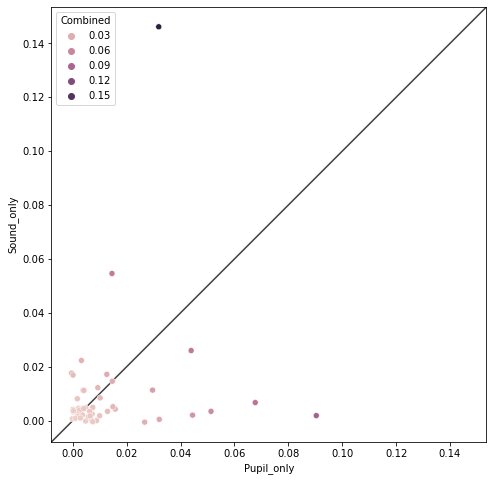

In [36]:
fig, ax = plt.subplots(figsize=(12,8))
sns.scatterplot(x='Pupil_only', y = 'Sound_only', data=score_df, hue='Combined', ax=ax)
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)


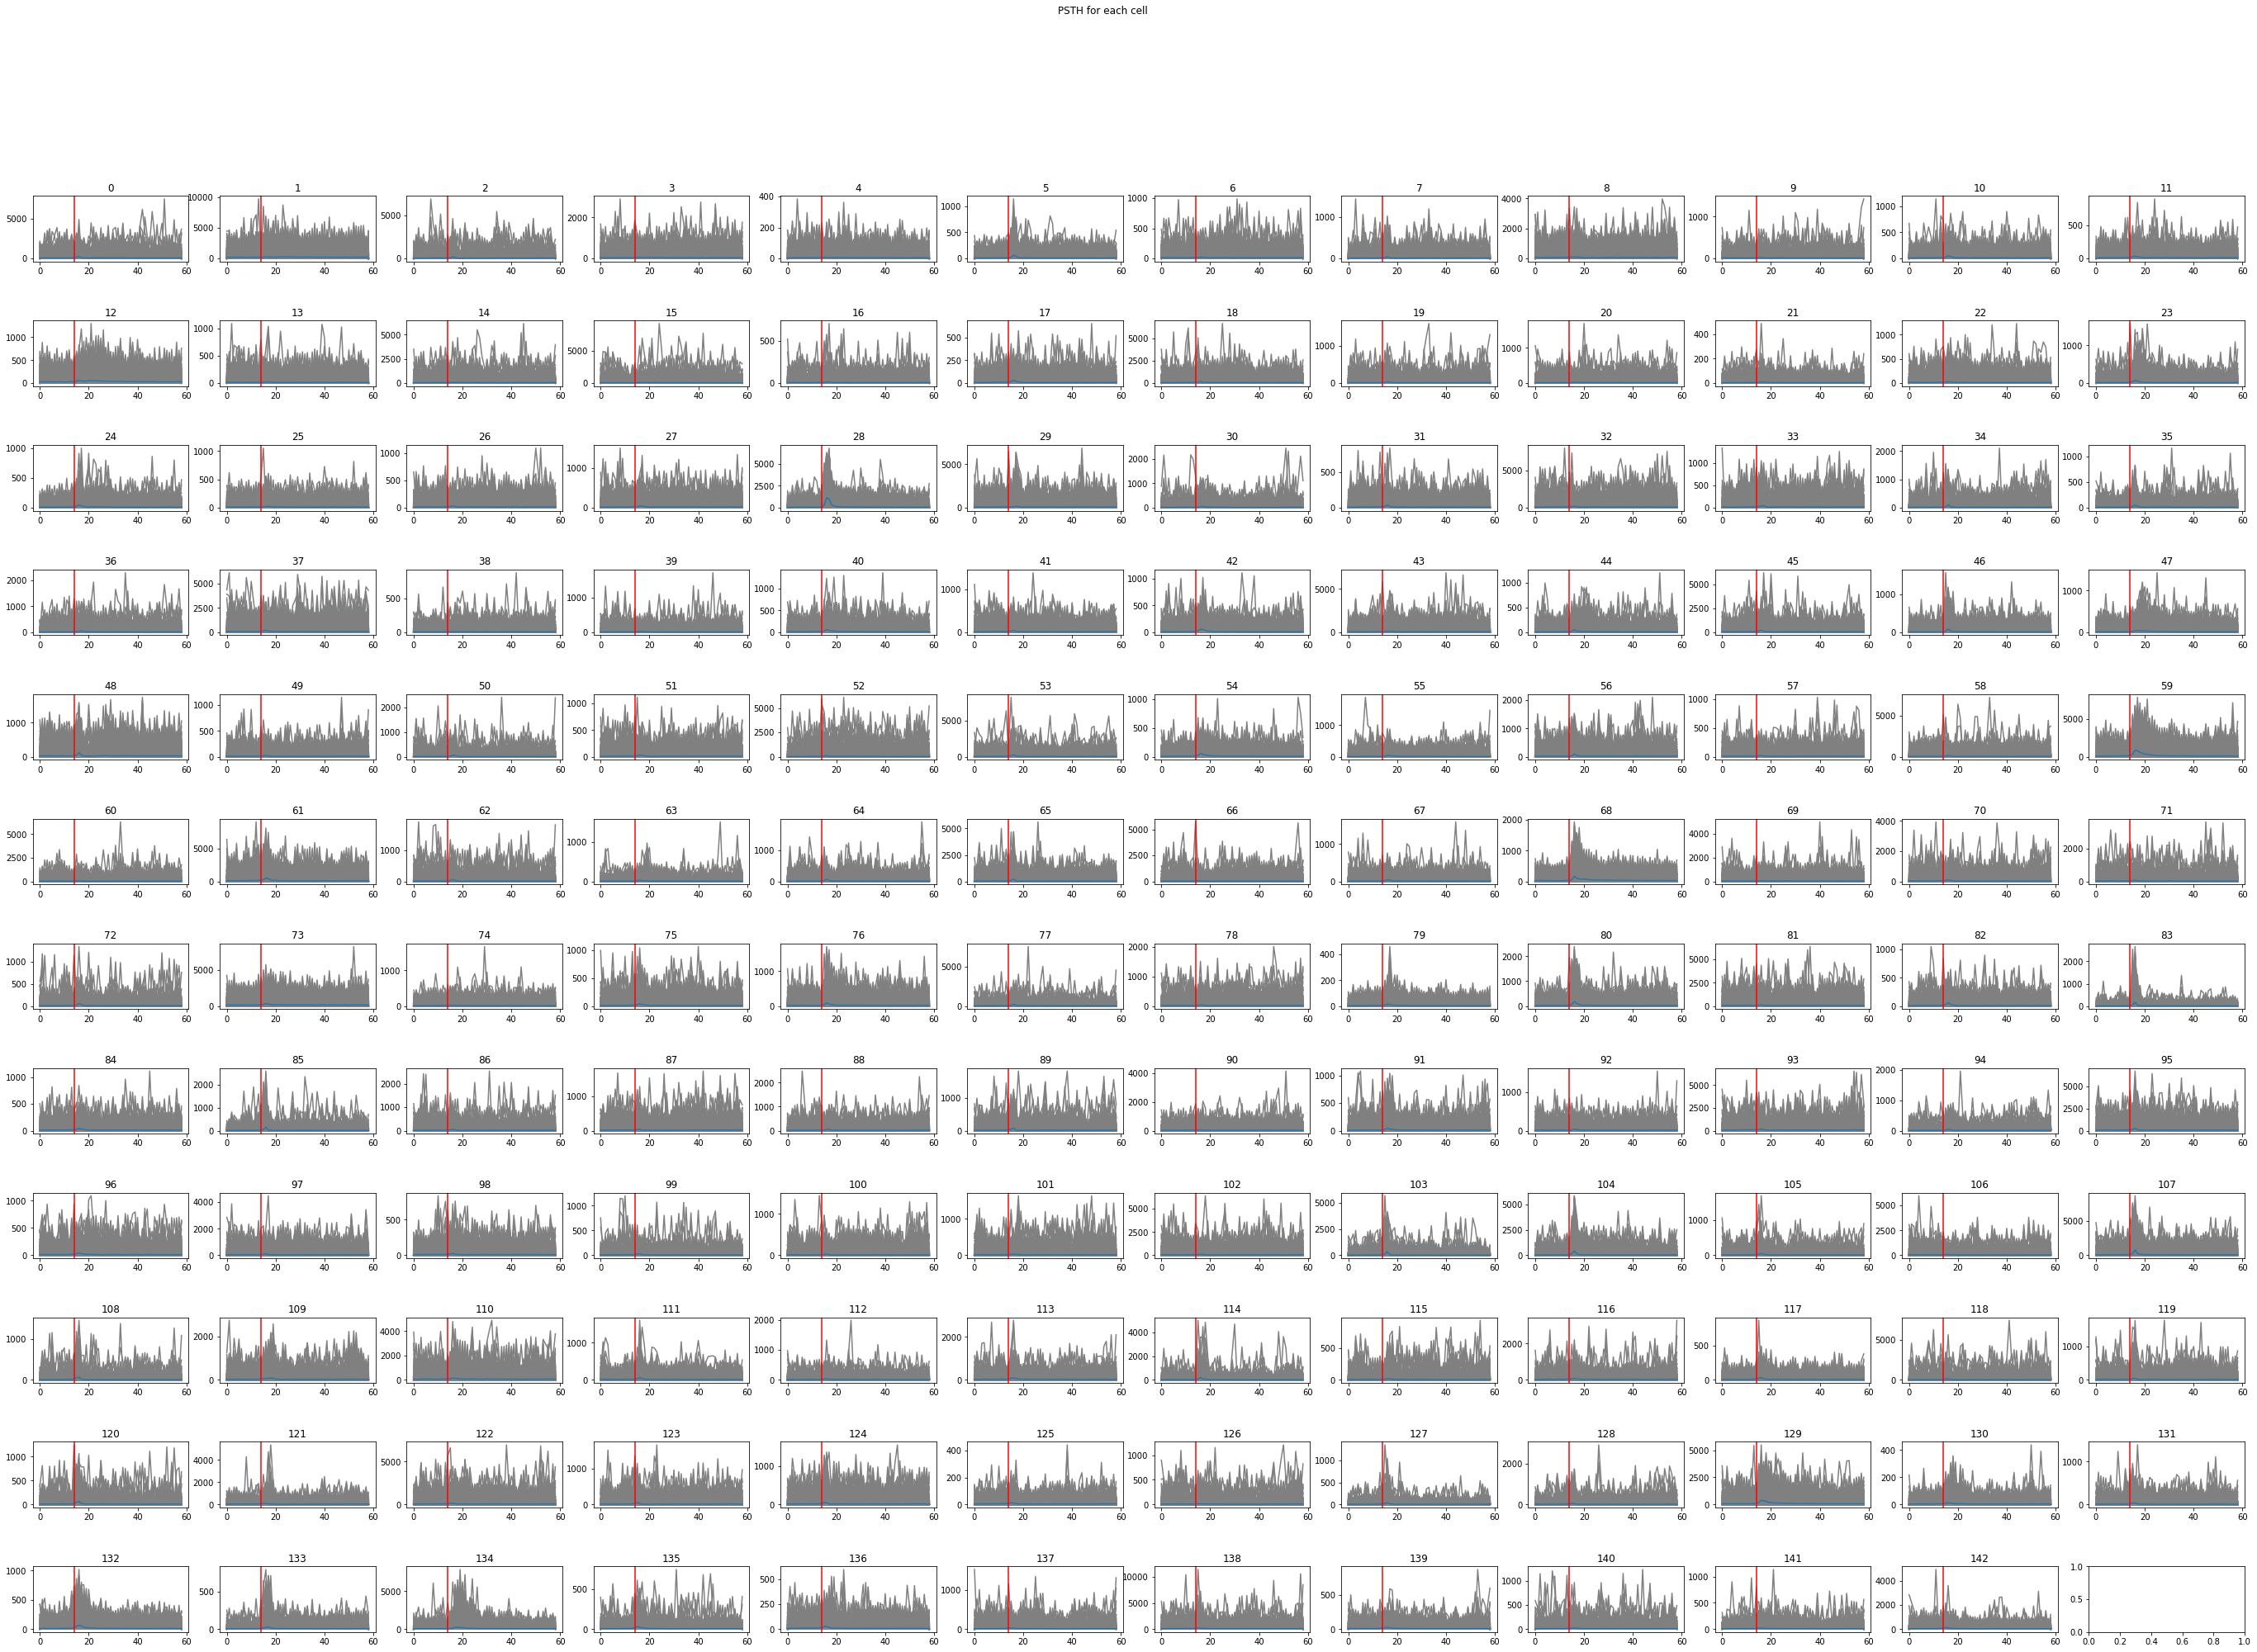

In [51]:
psth_plot(responsive_cells)

In [22]:
score_df.iloc[:,1:][score_df.Pupil_only > score_df.Sound_only]

,Combined,Sound_only,Pupil_only
1,0.075531,0.006705,0.067722
2,0.010108,0.002468,0.007221
6,0.004247,0.001250,0.002739
9,0.009251,0.000007,0.008846
10,0.007808,0.000734,0.006712
13,0.071577,0.026007,0.043933
18,0.009909,0.004743,0.004808
19,0.016565,0.003423,0.012890
20,0.005843,0.002132,0.003647
21,0.093000,0.001861,0.090366
